In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [2]:
path = os.listdir('SDSS_20k/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('SDSS_20k/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [3]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

872
15249
32951
37233
37879
45552
63104
63918
72767
81185
88285
96972
101023
122609


In [4]:
np.min(Image_RGB)

-0.1562042649972083

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (140976, 64, 64, 5)
train_label.shape: (140976, 3)


In [6]:
batch_size =100
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='tanh')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [7]:
autoencoder.fit(train_data[:100000], train_data[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(train_data[100000:140000],train_data[100000:140000]),callbacks=[EarlyStopping])

Train on 100000 samples, validate on 40000 samples
Epoch 1/100
100000/100000 [==============================] - 131s - loss: 0.1677 - val_loss: 0.1037
Epoch 2/100
100000/100000 [==============================] - 120s - loss: 0.1040 - val_loss: 0.1902
Epoch 3/100
100000/100000 [==============================] - 120s - loss: 0.0937 - val_loss: 0.0850- ETA: 2s - l - ETA: 1s - lo - ETA: 0s - loss: 0.
Epoch 4/100
100000/100000 [==============================] - 120s - loss: 0.0867 - val_loss: 0.0953
Epoch 5/100
100000/100000 [==============================] - 126s - loss: 0.0825 - val_loss: 0.1134
Epoch 6/100
100000/100000 [==============================] - 129s - loss: 0.0794 - val_loss: 0.0753
Epoch 7/100
100000/100000 [==============================] - 129s - loss: 0.0774 - val_loss: 0.0974
Epoch 8/100
100000/100000 [==============================] - 129s - loss: 0.0756 - val_loss: 0.0783
Epoch 9/100
100000/100000 [==============================] - 129s - loss: 0.0742 - val_loss: 0.0704


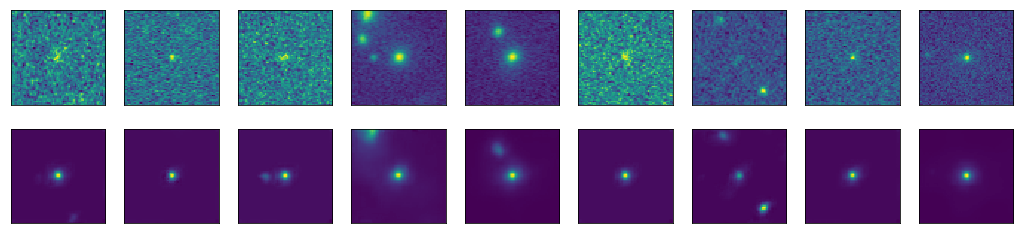

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = autoencoder.predict(train_data[0:100],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[0:100][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [9]:
encoder = Model(inputs=input_img, outputs=encoded)
encoded_variables = encoder.predict(train_data[:120000],batch_size=100)
encoded_variables.shape

(120000, 30)

In [10]:
net_2_input= Input(shape=(30,))
FC_1 = Dense(units=15, activation='relu')(net_2_input)
net_2_output = Dense(units=3, activation='sigmoid')(FC_1)

classifier = Model(net_2_input,net_2_output)
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')

In [11]:
classifier.fit(encoded_variables, label[:120000], batch_size=100, nb_epoch=40,shuffle=True,verbose=1,validation_split=0.2)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 96000 samples, validate on 24000 samples
Epoch 1/40
96000/96000 [==============================] - 4s - loss: 0.5004 - acc: 0.8304 - val_loss: 0.3330 - val_acc: 0.8684
Epoch 2/40
96000/96000 [==============================] - 4s - loss: 0.3105 - acc: 0.8846 - val_loss: 0.3032 - val_acc: 0.8891
Epoch 3/40
96000/96000 [==============================] - 4s - loss: 0.2921 - acc: 0.8964 - val_loss: 0.2910 - val_acc: 0.8947
Epoch 4/40
96000/96000 [==============================] - 4s - loss: 0.2829 - acc: 0.9019 - val_loss: 0.2874 - val_acc: 0.8970
Epoch 5/40
96000/96000 [==============================] - 4s - loss: 0.2765 - acc: 0.9044 - val_loss: 0.2788 - val_acc: 0.9007
Epoch 6/40
96000/96000 [==============================] - 4s - loss: 0.2715 - acc: 0.9057 - val_loss: 0.2753 - val_acc: 0.9023
Epoch 7/40
96000/96000 [==============================] - 4s - loss: 0.2676 - acc: 0.9071 - val_loss: 0.2721 - val_acc: 0.9030
Epoch 8/40
96000/96000 [==============================] - 4s 

In [12]:
Zero_one_normalized_encoded_variables = encoded_variables#/np.std(encoded_variables)/2

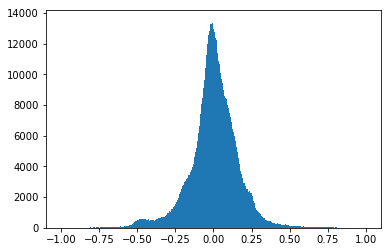

In [13]:
plt.hist(Zero_one_normalized_encoded_variables.reshape(-1,),2000)
plt.show()

In [14]:
Zero_one_normalized_encoded_variables.shape

(120000, 30)

# AE 

In [13]:
net_3_input= Input(shape=(30,))
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
encoded = Dense(2, activation='tanh')(net_3_input)
decoded = Dense(30, activation='tanh')(encoded)

autoencoder = Model(input=net_3_input, output=decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [14]:
autoencoder.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 3s - loss: 0.0226 - val_loss: 0.0178
Epoch 2/100
96000/96000 [==============================] - 3s - loss: 0.0185 - val_loss: 0.0176
Epoch 3/100
96000/96000 [==============================] - 3s - loss: 0.0184 - val_loss: 0.0175
Epoch 4/100
96000/96000 [==============================] - 3s - loss: 0.0184 - val_loss: 0.0175
Epoch 5/100
96000/96000 [==============================] - 3s - loss: 0.0183 - val_loss: 0.0175
Epoch 6/100
96000/96000 [==============================] - 3s - loss: 0.0183 - val_loss: 0.0175
Epoch 7/100
96000/96000 [==============================] - 3s - loss: 0.0183 - val_loss: 0.0175
Epoch 8/100
96000/96000 [==============================] - 3s - loss: 0.0183 - val_loss: 0.0175
Epoch 9/100
96000/96000 [==============================] - 3s - loss: 0.0183 - val_loss: 0.0175
Epoch 10/100
96000/96000 [==============================] - 3s - loss: 0.0183 - val_lo

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


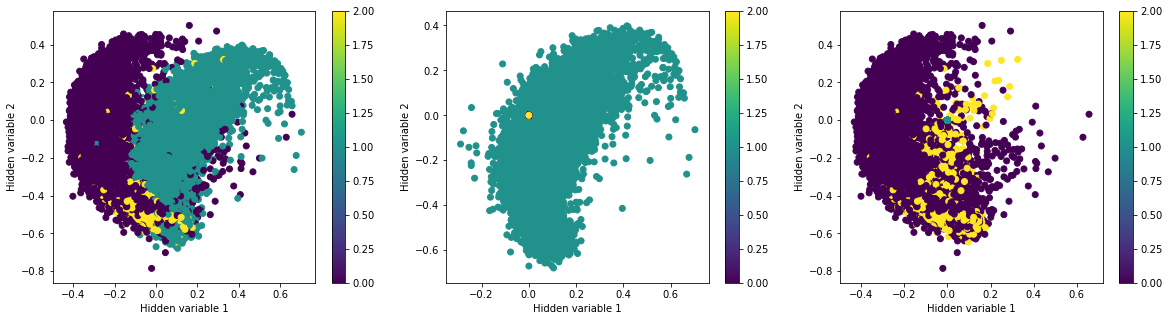

In [15]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]!=1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [20]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if 2*x_vis[i,0] + x_vis[i,1]+0.2<0 or x_vis[i,1]>1*x_vis[i,0]+0.2:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1
(star_corr + gala_corr)/upper_lim

0.7206583333333333

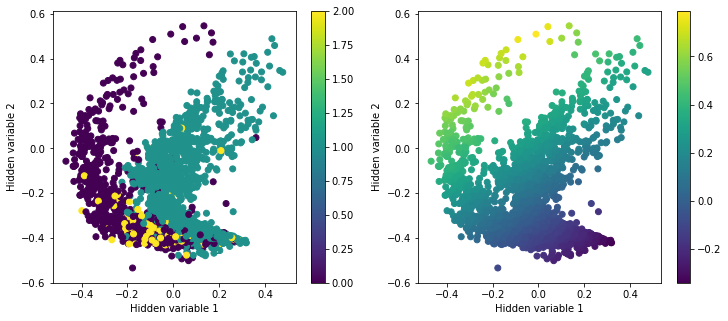

In [21]:
lower_lim = 0
upper_lim = 3000


x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [22]:
n_neighbors = 10
n_components = 1
X = np.asarray(hid_pred,dtype='float64')
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y_pred = se.fit_transform(X)

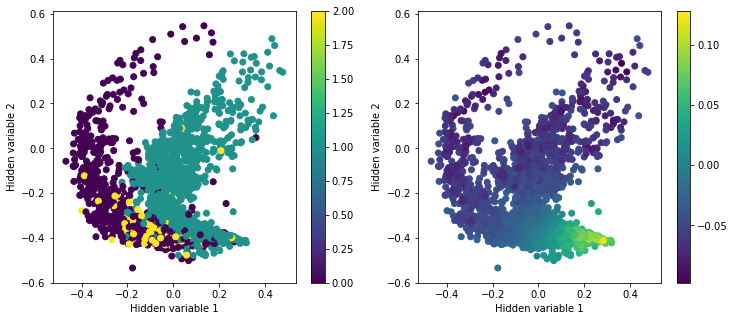

In [23]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [24]:
methods = ['standard', 'ltsa', 'hessian', 'modified']
Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=methods[3]).fit_transform(X)

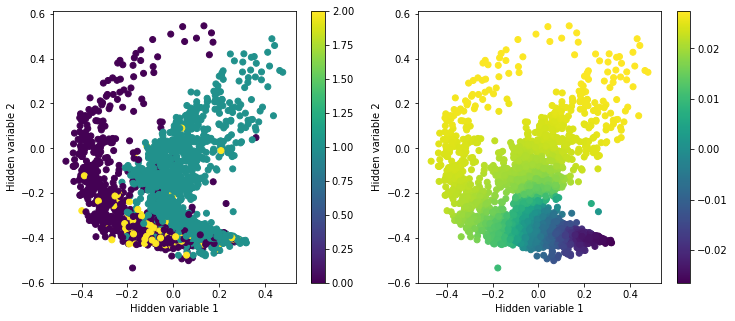

In [25]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [26]:
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)

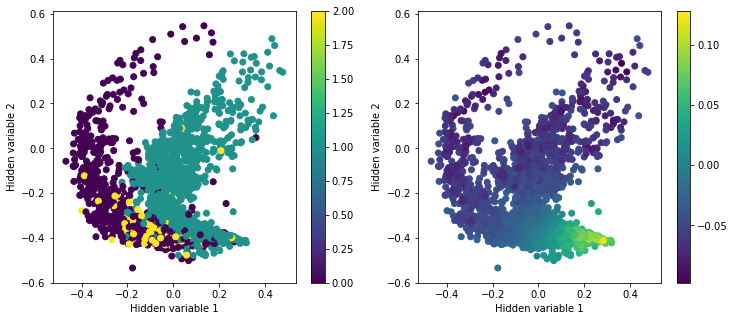

In [27]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

# VAE KLterm = 0.1

In [39]:
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)
z_mean = Dense(2)(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.1*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [40]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 8s - loss: 0.8013 - val_loss: 0.0196
Epoch 2/100
96000/96000 [==============================] - 7s - loss: 0.0490 - val_loss: -0.0233
Epoch 3/100
96000/96000 [==============================] - 7s - loss: 0.0267 - val_loss: -0.0396
Epoch 4/100
96000/96000 [==============================] - 7s - loss: 0.0172 - val_loss: -0.0442
Epoch 5/100
96000/96000 [==============================] - 7s - loss: 0.0117 - val_loss: -0.0515
Epoch 6/100
96000/96000 [==============================] - 7s - loss: 0.0079 - val_loss: -0.0537
Epoch 7/100
96000/96000 [==============================] - 7s - loss: 0.0055 - val_loss: -0.0569
Epoch 8/100
96000/96000 [==============================] - 7s - loss: 0.0036 - val_loss: -0.0583
Epoch 9/100
96000/96000 [==============================] - 8s - loss: 0.0024 - val_loss: -0.0549
Epoch 10/100
96000/96000 [==============================] - 7s - loss: 0.0012 

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


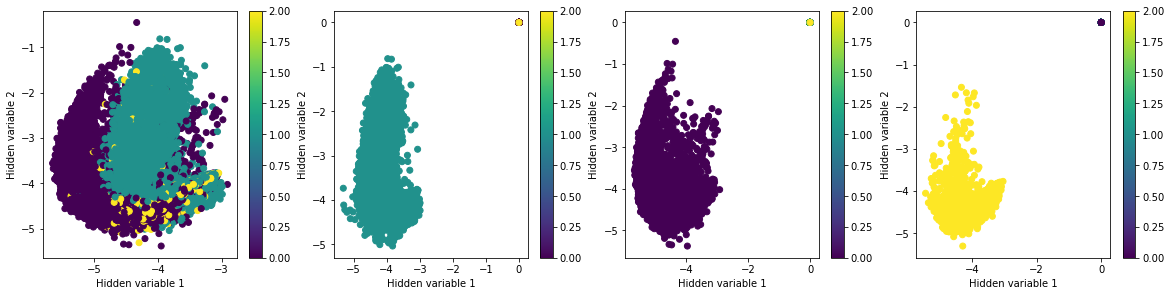

In [41]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]!=1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]!=0]=0

x_vis_3 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_3[label_value[lower_lim:upper_lim]!=2]=0

plt.figure(figsize=(20, 10))

ax = plt.subplot(2,4,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(2,4,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(2,4,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(2,4,4)
plt.scatter( x_vis_3[:, 0] ,x_vis_3[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [37]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,0]>0.:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [38]:
(star_corr + gala_corr)/upper_lim

0.615925

# VAE KLterm = 0.3

In [122]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.3*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [123]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 7s - loss: -0.0682 - val_loss: -0.4435
Epoch 2/100
96000/96000 [==============================] - 6s - loss: -0.3827 - val_loss: -0.4472
Epoch 3/100
96000/96000 [==============================] - 6s - loss: -0.3849 - val_loss: -0.4449
Epoch 4/100
96000/96000 [==============================] - 6s - loss: -0.3868 - val_loss: -0.4506
Epoch 5/100
96000/96000 [==============================] - 6s - loss: -0.3897 - val_loss: -0.4518
Epoch 6/100
96000/96000 [==============================] - 6s - loss: -0.3924 - val_loss: -0.4530
Epoch 7/100
96000/96000 [==============================] - 6s - loss: -0.3945 - val_loss: -0.4546
Epoch 8/100
96000/96000 [==============================] - 6s - loss: -0.3958 - val_loss: -0.4559
Epoch 9/100
96000/96000 [==============================] - 7s - loss: -0.3964 - val_loss: -0.4571
Epoch 10/100
96000/96000 [==============================] - 7s - los

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


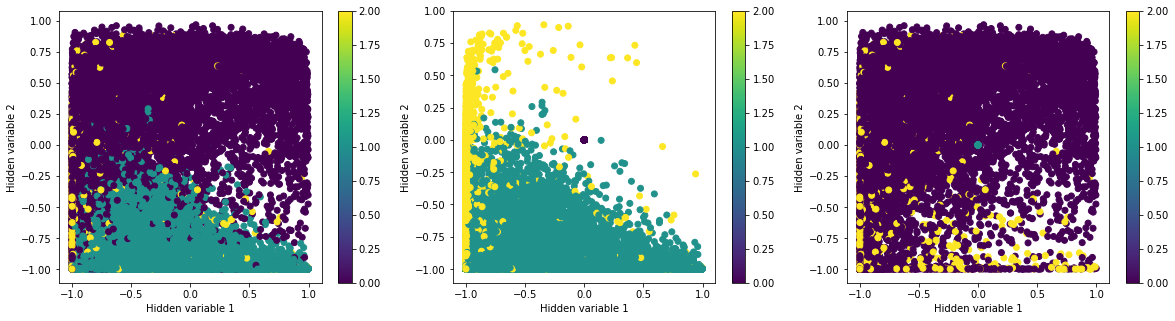

In [124]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [94]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,0]>-0.65:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [95]:
(star_corr + gala_corr)/upper_lim

0.8395666666666667

In [ ]:
#vis = Model(input=net_3_input, output=z_mean)
#x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = -x_vis[:,1]
thr_min = -1.2
thr_max = 1.2
test_accuracy = 0.0001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

23999


# VAE KLterm=0.05

In [100]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(1,activation='tanh')(h_1)
z_log_var = Dense(1)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.05*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [101]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 9s - loss: 1.6956 - val_loss: 1.4315
Epoch 2/100
96000/96000 [==============================] - 8s - loss: 1.4879 - val_loss: 1.4260
Epoch 3/100
96000/96000 [==============================] - 8s - loss: 1.4863 - val_loss: 1.4255
Epoch 4/100
96000/96000 [==============================] - 8s - loss: 1.4862 - val_loss: 1.4243
Epoch 5/100
96000/96000 [==============================] - 8s - loss: 1.4851 - val_loss: 1.4231
Epoch 6/100
96000/96000 [==============================] - 8s - loss: 1.4840 - val_loss: 1.4219
Epoch 7/100
96000/96000 [==============================] - 8s - loss: 1.4831 - val_loss: 1.4223
Epoch 8/100
96000/96000 [==============================] - 9s - loss: 1.4823 - val_loss: 1.4197
Epoch 9/100
96000/96000 [==============================] - 8s - loss: 1.4817 - val_loss: 1.4217
Epoch 10/100
96000/96000 [==============================] - 9s - loss: 1.4815 - val_lo

22000
AUC: 0.859126514485


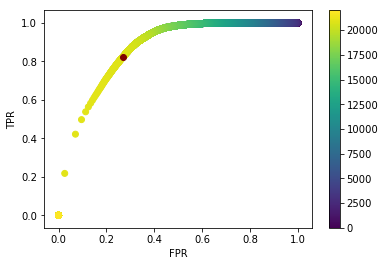

In [104]:
#vis = Model(input=net_3_input, output=z_mean)
#x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = -x_vis[:,0]
thr_min = -1.1
thr_max = 1.1
test_accuracy = 0.0001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


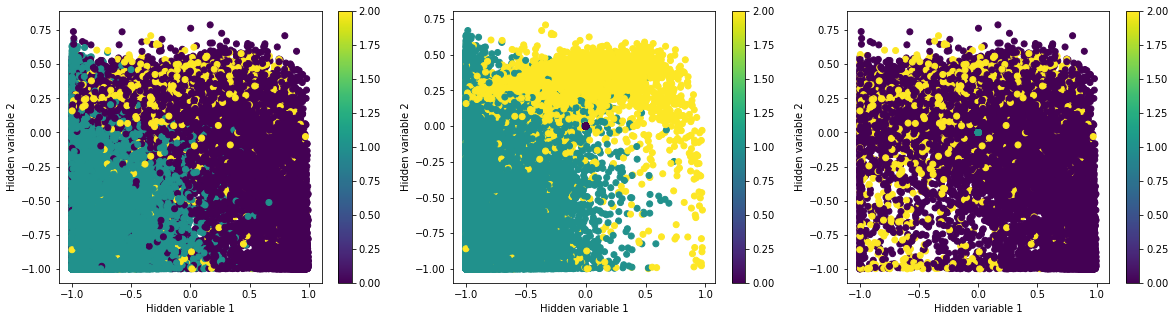

In [202]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [208]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,0]>0 or x_vis[i,1]>0.25:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [209]:
(star_corr + gala_corr)/upper_lim

0.8822416666666667

# m=0.5 VAE KLterm=0.05

In [114]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(1,activation='tanh')(h_1)
z_log_var = Dense(1)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(0.7)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.005*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [115]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 7s - loss: 1.7529 - val_loss: 1.5290
Epoch 2/100
96000/96000 [==============================] - 6s - loss: 1.5897 - val_loss: 1.5278
Epoch 3/100
96000/96000 [==============================] - 6s - loss: 1.5880 - val_loss: 1.5261
Epoch 4/100
96000/96000 [==============================] - 6s - loss: 1.5870 - val_loss: 1.5258
Epoch 5/100
96000/96000 [==============================] - 6s - loss: 1.5865 - val_loss: 1.5252
Epoch 6/100
96000/96000 [==============================] - 6s - loss: 1.5860 - val_loss: 1.5243
Epoch 7/100
96000/96000 [==============================] - 6s - loss: 1.5857 - val_loss: 1.5244
Epoch 8/100
96000/96000 [==============================] - 6s - loss: 1.5852 - val_loss: 1.5237
Epoch 9/100
96000/96000 [==============================] - 6s - loss: 1.5850 - val_loss: 1.5237
Epoch 10/100
96000/96000 [==============================] - 6s - loss: 1.5844 - val_lo

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


220
AUC: 0.5565265657


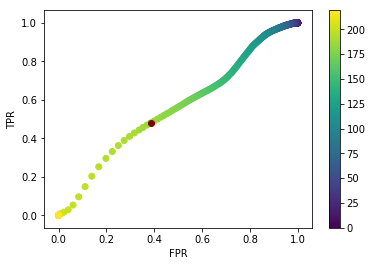

In [116]:
vis = Model(input=net_3_input, output=z_mean)
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = -x_vis[:,0]
thr_min = -1.1
thr_max = 1.1
test_accuracy = 0.01
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


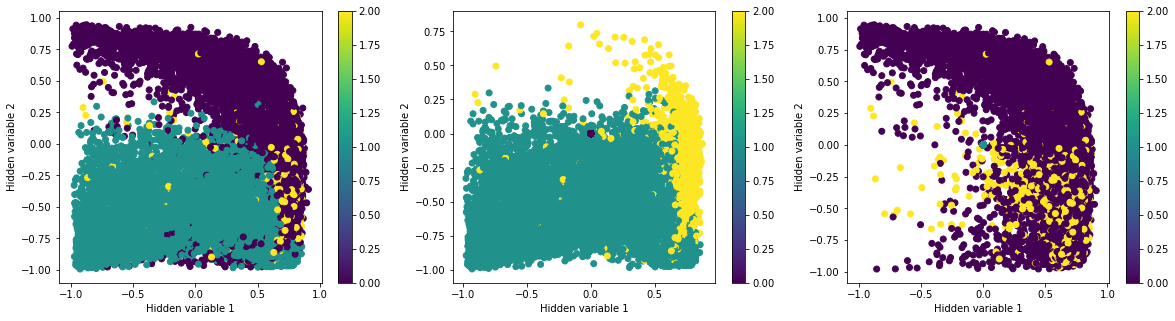

In [217]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [236]:
star_corr = 0
gala_corr = 0
for i in range(upper_lim):
    if x_vis[i,1]>0.1 or x_vis[i,0]>0.68:
        if label_value[i]==0 or label_value[i]==2:
            star_corr+=1
    else:
        if label_value[i]==1:
            gala_corr+=1

In [237]:
(star_corr + gala_corr)/upper_lim

0.9080333333333334

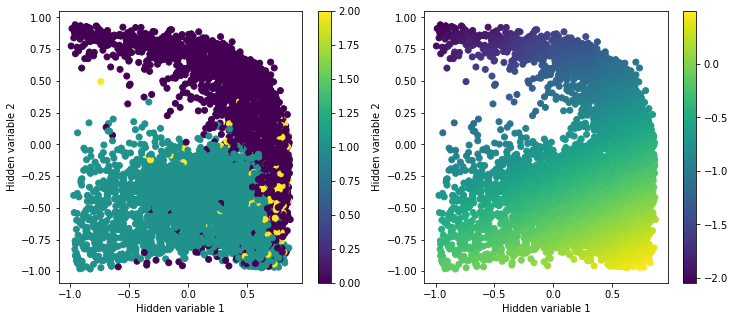

In [241]:
lower_lim = 0
upper_lim = 30000


x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

3000
AUC: 0.721767195864


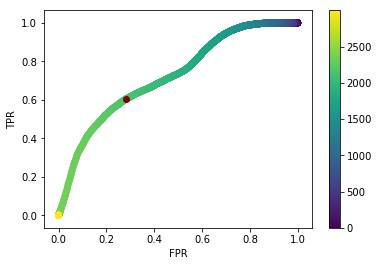

In [242]:
#Y_pred = -Y_pred
thr_min = -2
thr_max = 1
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

# VAE baseline

In [109]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(1)(h_1)
z_log_var = Dense(1)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(0)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.005*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [110]:
vae.fit(Zero_one_normalized_encoded_variables[:120000], Zero_one_normalized_encoded_variables[:120000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
96000/96000 [==============================] - 8s - loss: 1.7953 - val_loss: 1.5326
Epoch 2/100
96000/96000 [==============================] - 6s - loss: 1.5911 - val_loss: 1.5294
Epoch 3/100
96000/96000 [==============================] - 6s - loss: 1.5906 - val_loss: 1.5291
Epoch 4/100
96000/96000 [==============================] - 6s - loss: 1.5902 - val_loss: 1.5291
Epoch 5/100
96000/96000 [==============================] - 8s - loss: 1.5900 - val_loss: 1.5281
Epoch 6/100
96000/96000 [==============================] - 8s - loss: 1.5897 - val_loss: 1.5283
Epoch 7/100
96000/96000 [==============================] - 8s - loss: 1.5895 - val_loss: 1.5287
Epoch 8/100
96000/96000 [==============================] - 8s - loss: 1.5890 - val_loss: 1.5280
Epoch 9/100
96000/96000 [==============================] - 7s - loss: 1.5888 - val_loss: 1.5270
Epoch 10/100
96000/96000 [==============================] - 7s - loss: 1.5886 - val_lo

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


220
AUC: 0.448957077582


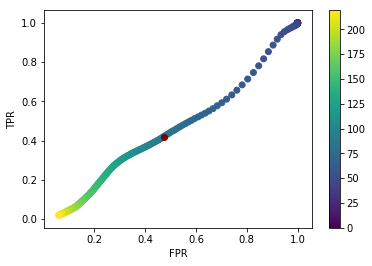

In [113]:
vis = Model(input=net_3_input, output=z_mean)
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = -x_vis[:,0]
thr_min = -1.1
thr_max = 1.1
test_accuracy = 0.01
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))